In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import equinox as eqx

import optax

import timeit

from scipy.stats import qmc

In [2]:
model_key = jax.random.PRNGKey(1)

input_dim = 2
output_dim = 'scalar'

layers_size = 10
n_layers = 1

model = eqx.nn.MLP(in_size=input_dim, out_size=output_dim, width_size=layers_size, depth=n_layers,
                    activation=jax.nn.sigmoid, use_final_bias=False, key=model_key)

In [323]:
sigma = 0.5**2


L = 3
T = 70

a = 0.75
b = 0.75


v_max = 1.5
p_max = 1 # rho_max cannot be learned Susana's paper

In [324]:
def p_in_steady(a, vm, pm):

    p1 = (vm + a)/(2*vm)
    p2 = jnp.sqrt(vm**2 + 2*vm*a + a**2 - 4*vm*a*pm)/(2*vm)

    return p1-p2 #p1+p2,

In [325]:
p_in_steady(a, v_max, p_max)

Array(0.5, dtype=float32, weak_type=True)

In [326]:
# Example batch input

batch_input_data = jnp.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
])

In [327]:
def func(rho):
    return v_max*(1-rho/p_max)

def d_func(rho):
    return -(v_max/p_max) + 0*rho

In [328]:
def pde_loss(model, input, sigma):
    
    # p = rho

    rho, grad = jax.vmap(jax.value_and_grad(model))(input)
    hess = jax.vmap(jax.hessian(model))(input)

    dp_dx = grad[:, 0] 
    dp_dt = grad[:, 1]
    d2p_dx2 = hess[:, 0, 0]


    fp = func(rho)
    df_p = d_func(rho)

    return jnp.mean((dp_dt - sigma*d2p_dx2 + dp_dx*(fp + rho*df_p))**2)

In [329]:
def steady_state_loss(model, L, sigma, steps=50):
    
    # p = rho
    x = jnp.linspace(0, L, steps)
    t_flat = jnp.full_like(x, 100)
    result = jnp.stack((x, t_flat), axis=-1)

    rho, grad = jax.vmap(jax.value_and_grad(model))(result)
    hess = jax.vmap(jax.hessian(model))(result)

    dp_dx = grad[:, 0] 
    dp_dt = grad[:, 1]
    d2p_dx2 = hess[:, 0, 0]
    d2p_dt2 = hess[:, 1, 1]


    #fp = func(rho)
    #df_p = d_func(rho)

    #return jnp.mean((sigma*d2p_dx2 + dp_dx*(fp + rho*df_p))**2)+jnp.mean(dp_dt**2)
    return jnp.mean(dp_dt**2+d2p_dt2**2)

In [330]:
def p_in_steady_loss(model):
    result = jnp.array([0,70])
    rho_0 = model(result)
    s = jnp.array(p_in_steady(a, v_max, p_max))

    return (rho_0 - s)**2

In [331]:
p_in_steady_loss(model)

Array(92.25657, dtype=float32)

In [332]:
steady_state_loss(model, L, sigma, steps=50)

Array(0.02005894, dtype=float32)

In [333]:
steady_state_loss(model, L, sigma, steps=50)

Array(0.02005894, dtype=float32)

In [334]:
pde_loss(model, batch_input_data, sigma)

Array(0.00877587, dtype=float32)

In [335]:
def func_j(model, input, sigma):
    rho, grad = jax.vmap(jax.value_and_grad(model))(input)
    j = -sigma*grad[:, 0] + rho * func(rho)

    return j, rho

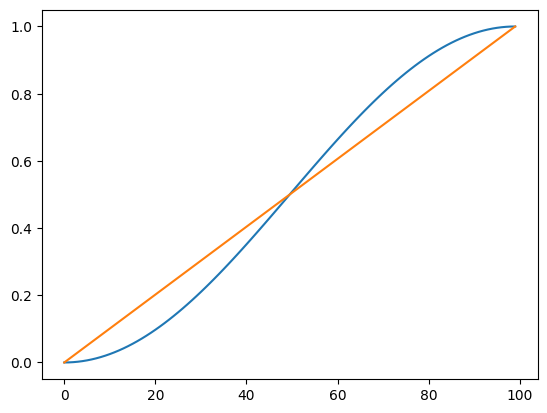

In [336]:
def cosine_spacing(start, end, steps):
    linspace = jnp.linspace(0, jnp.pi, steps)
    cosine_values = (1 - jnp.cos(linspace))/2  # This maps the values to [0, 1]
    return start + (end - start) * cosine_values

T = 1.0
steps = 100
unequal_spaced_array = cosine_spacing(0.00, T, steps)
plt.plot(unequal_spaced_array)
plt.plot(jnp.linspace(0, 1., 100))
plt.show()


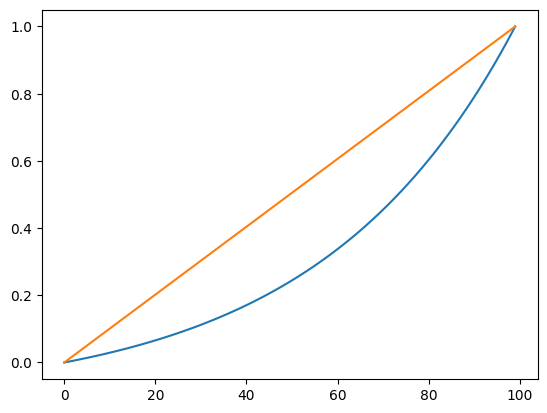

In [337]:
def exponential_spacing(start, end, steps, exp_base=2):
    linspace = jnp.linspace(0, 1, steps)
    exp_values = (exp_base ** linspace - 1) / (exp_base - 1)  # This maps the values to [0, 1]
    return start + (end - start) * exp_values

T = 1.0
steps = 100
unequal_spaced_array = exponential_spacing(0.00, T, steps, 10)
plt.plot(unequal_spaced_array)
plt.plot(jnp.linspace(0, 1., 100))
plt.show()


In [338]:
def in_loss(model, T, sigma, a, steps=50):
    t = jnp.linspace(0.00, T, steps)
    x_flat = jnp.zeros_like(t)
    result = jnp.stack((x_flat, t), axis=-1)
    j, rho = func_j(model, result, sigma)

    lhs = -j
    rhs = -a*(p_max - rho)

    return jnp.mean((lhs-rhs)**2)

In [339]:
def out_loss(model, T, L, sigma, b, steps=50):
    t = jnp.linspace(0.00, T, steps)
    x_flat = jnp.full_like(t, L)
    result = jnp.stack((x_flat, t), axis=-1)
    j, rho = func_j(model, result, sigma)

    lhs = j
    rhs = b*rho

    return jnp.mean((lhs-rhs)**2)

In [340]:
def time_loss(model, L, steps=50):
    x = cosine_spacing(0, L, steps)
    t_flat = jnp.zeros_like(x)
    result = jnp.stack((x, t_flat), axis=-1)

    rho = jax.vmap(model)(result)

    return jnp.mean(rho**2)


In [356]:
def loss(model, input, L, T, sigma, a, b, steps=50):

    return ( pde_loss(model, input, sigma) + steady_state_loss(model, L, sigma, steps) + in_loss(model, T, sigma, a, steps) + 
            out_loss(model, T, L, sigma, b, steps)
            + time_loss(model, L, steps))

In [357]:
loss(model, batch_input_data, L, T, sigma, a, b)

Array(0.02957602, dtype=float32)

In [358]:
def generate_latin_hypercube_samples(num_samples, x1, t):
    # Define the ranges
    parameter_ranges = jnp.array([x1, t])
    
    # Create a Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d=len(parameter_ranges))
    
    # Sample points in the hypercube
    sample_points = sampler.random(n=num_samples)
    
    # Scale the points
    scaled_samples = qmc.scale(sample_points, parameter_ranges[:, 0], parameter_ranges[:, 1])
    
    return jnp.array(scaled_samples)

In [359]:
# Define a Multilayer Perceptron

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for layer in self.layers[:-1]:
            x = jax.nn.gelu(layer(x))
        
        x = self.layers[-1](x)
        return x

In [360]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def train_step(model, opt_state, input, L, T, sigma, a, b, steps=20):
    loss_value, grads = jax.value_and_grad(loss)(model, input, L, T, sigma, a, b, steps) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

In [370]:
# Initialize the model with multiple hidden layers and scalar output layer
model_key = jax.random.PRNGKey(1)


output_dim = 'scalar'

model = MLP(model_key, input_dim=2, hidden_dims=256, n_layers=6, output_dim=output_dim)

In [371]:
# Optimizer definition
lr = 10e-5
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(model)

In [372]:
# Training loop
num_epochs = 10000
losses = []



sample_n = 100
x = generate_latin_hypercube_samples(sample_n*num_epochs, [0,L], [0.0,T]) # Latin Hypercube sample


for epoch in range(num_epochs):
    
    sample = x[epoch*sample_n:(epoch+1)*sample_n]
    model, opt_state, loss_value = train_step(model, opt_state, sample, L, T, sigma, a, b, steps=50)
    if epoch % 100 == 0:
        losses.append(loss_value)
        print(f"Epoch {epoch}, Loss: {loss_value}")


    if epoch % 1000 == 0:
        lr *= 0.4
        optimizer = optax.adam(learning_rate=lr)
        opt_state = optimizer.init(model)  # Re-initialize optimizer state with new learning rate

        

# Print final loss
x = generate_latin_hypercube_samples(sample_n, [0,L], [0,T]) # Latin Hypercube sample
final_loss = loss(model, x, L, T, sigma, a, b, steps=20)
print(f"Final Loss: {final_loss}")

Epoch 0, Loss: 0.5517347455024719
Epoch 100, Loss: 0.02777743898332119
Epoch 200, Loss: 0.020069265738129616
Epoch 300, Loss: 0.015409857034683228
Epoch 400, Loss: 0.011692924425005913
Epoch 500, Loss: 0.009830924682319164
Epoch 600, Loss: 0.008458420634269714
Epoch 700, Loss: 0.008293773978948593
Epoch 800, Loss: 0.00688689760863781
Epoch 900, Loss: 0.006594299338757992
Epoch 1000, Loss: 0.005080008413642645
Epoch 1100, Loss: 0.004741739947348833
Epoch 1200, Loss: 0.0037484688218683004
Epoch 1300, Loss: 0.0035468214191496372
Epoch 1400, Loss: 0.0032744091004133224
Epoch 1500, Loss: 0.0029807311948388815
Epoch 1600, Loss: 0.002888898830860853
Epoch 1700, Loss: 0.002879719017073512
Epoch 1800, Loss: 0.0020992769859731197
Epoch 1900, Loss: 0.0022472823038697243
Epoch 2000, Loss: 0.001967264572158456
Epoch 2100, Loss: 0.001988382777199149
Epoch 2200, Loss: 0.001978266052901745
Epoch 2300, Loss: 0.0018662938382476568
Epoch 2400, Loss: 0.002605617977678776
Epoch 2500, Loss: 0.00184738240204

KeyboardInterrupt: 

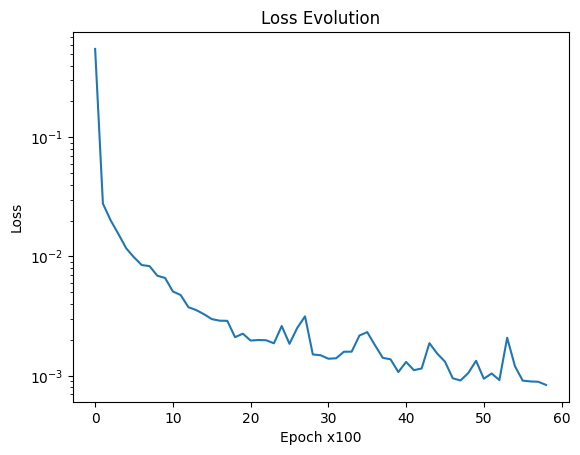

In [373]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch x100')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.show()

In [374]:
batch = generate_latin_hypercube_samples(5000, [0,L], [0.0,T]) 

In [375]:
print(pde_loss(model, batch, sigma))
print(steady_state_loss(model, L, sigma))
print(in_loss(model, T, sigma, a))
print(out_loss(model, T, L, sigma, b))
print(time_loss(model, L))
print(p_in_steady_loss(model))

0.00018687753
2.1078022e-09
0.00010861241
2.676956e-06
0.0008062801
0.2705588


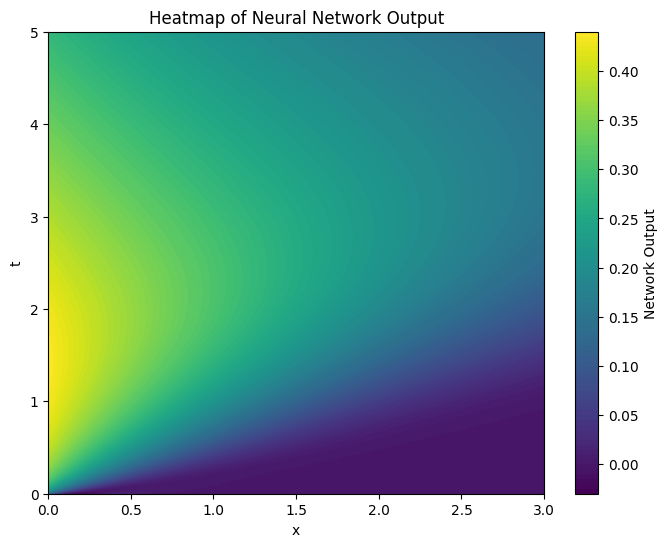

In [376]:
n_points = 300
#x = jnp.concat([jnp.linspace(0, 0.5, n_points), jnp.linspace(0.5, L-0.5, n_points), jnp.linspace(L-0.5, L, n_points)])
x = jnp.linspace(0, L, n_points)
t = jnp.linspace(0, 5*T, n_points)
X_grid, T_grid = jnp.meshgrid(x, t)
inputs = jnp.stack((X_grid.flatten(), T_grid.flatten()), axis=-1)


outputs = jax.vmap(model)(inputs)
outputs = outputs.reshape(len(t), len(x))


plt.figure(figsize=(8, 6))
plt.contourf(X_grid, T_grid, outputs, levels=100, cmap='viridis')
plt.colorbar(label='Network Output')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Heatmap of Neural Network Output')
plt.show()

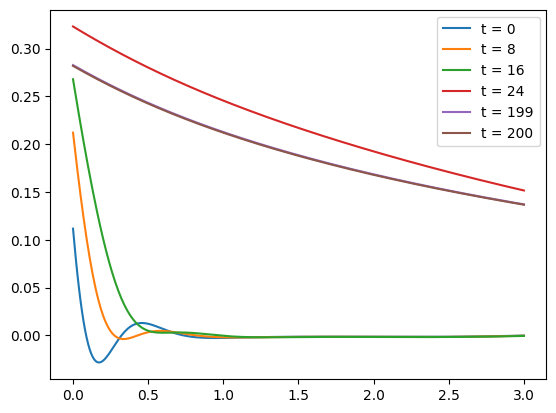

In [377]:
plt.plot(x,outputs[0], label='t = 0')
plt.plot(x,outputs[2], label='t = 8')
plt.plot(x,outputs[5], label='t = 16')
plt.plot(x,outputs[250], label='t = 24')
plt.plot(x,outputs[-2], label='t = 199')
plt.plot(x,outputs[-1], label='t = 200')
#plt.ylim([0.4, 0.6])
plt.legend()
plt.show()

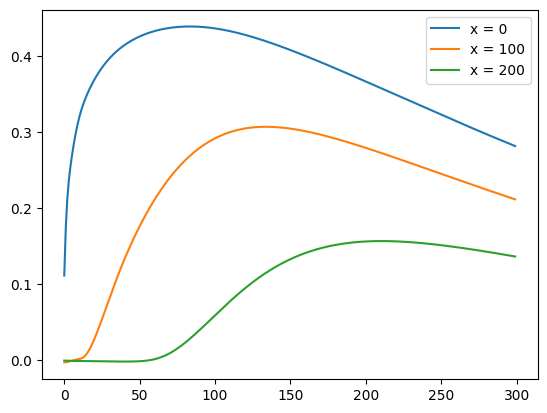

In [378]:
plt.plot(outputs.T[0], label='x = 0')
plt.plot(outputs.T[100], label='x = 100')
plt.plot(outputs.T[-1], label='x = 200')
plt.legend()
plt.show()